In [1]:
import pandas as pd
import numpy as np
import re
import datetime as datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler
from sklearn.preprocessing import TargetEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold,SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression, LassoCV 
from sklearn.metrics import mean_absolute_error,mean_squared_error


Dataset learning and the basic dataset processing is describing below.

In [2]:
#Read the csv dataset
canadian_rental = pd.read_csv('canada_rent.csv')

# Get the information about dataset
canadian_rental.info()

#Learn more about dataset on how many numerical and categorical features there are in the dataset
canadian_rental_numerical = canadian_rental.select_dtypes(include=['int64','float64','number']).shape[1]
canadian_rental_categorical = canadian_rental.select_dtypes(include=['object','category']).count().shape[0]

print(f'\nThis datase has {canadian_rental_numerical} numeric features  and {canadian_rental_categorical} categorical features')

#Get the description of the dataset
canadian_rental.describe()
canadian_rental.shape
canadian_rental.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rentfaster_id      25771 non-null  int64  
 1   city               25771 non-null  object 
 2   province           25771 non-null  object 
 3   address            25646 non-null  object 
 4   latitude           25771 non-null  float64
 5   longitude          25771 non-null  float64
 6   lease_term         25725 non-null  object 
 7   type               25771 non-null  object 
 8   price              25771 non-null  float64
 9   beds               25639 non-null  object 
 10  baths              25637 non-null  object 
 11  sq_feet            21659 non-null  object 
 12  link               25771 non-null  object 
 13  furnishing         25771 non-null  object 
 14  availability_date  25759 non-null  object 
 15  smoking            23069 non-null  object 
 16  cats               255

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
1,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2695.0,3 Beds,2.5,1496,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
2,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2295.0,2 Beds,2.5,1180,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True


Defining a function to clean the 'sq_feet' feature as it had text and numbers mixed up.

In [3]:
# Data conversion
# Cleaning the 'availability_date' needed to handle'immediate', various date convertions, 'call for availability', 'negitiable'
# canadian_rental['availability_date'].unique()

# Function to clean the 'availability_date' column
def clean_availability_date(date_value):
    """
    Cleans and standardizes the availability_date column:
    - Converts valid date-like values to YYYY-MM-DD.
    - Handles missing year by assuming the nearest upcoming year.
    - Converts relative terms ('Immediate', 'Negotiable', etc.) to a standardized format.
    - Leaves NaN for unknown or invalid values.
    """
    
    # Handle missing values
    if pd.isna(date_value):
        return None
    
    # Handle timestamps (already in correct format)
    if isinstance(date_value, pd.Timestamp):
        return date_value.date()  # Convert Timestamp to Date
    
    # Convert to string
    date_str = str(date_value).strip()
    
    # Handle relative terms
    if date_str.lower() in ['immediate']:
        return datetime.datetime.today().date()  # Assign today's date
    if date_str.lower() in ['negotiable', 'call for availability', 'no vacancy']:
        return None  # Assign NaN for unknown availability
    
    # Regex pattern to match "Month Day" format (e.g., "July 01", "September 15")
    month_day_pattern = r'([A-Za-z]+) (\d{1,2})'
    
    match = re.match(month_day_pattern, date_str)
    if match:
        month, day = match.groups()
        
        # Convert month name to number
        month_number = datetime.datetime.strptime(month, "%B").month
        
        # Assume the year is the current year or next year if the date has passed
        today = datetime.datetime.today()
        year = today.year
        if datetime.datetime(year, month_number, int(day)) < today:
            year += 1  # Assign next year if the date has passed
        
        # Convert to YYYY-MM-DD format
        return datetime.datetime(year, month_number, int(day)).date()

    return None  # Default case: Return None for invalid entries

# Apply cleaning function
canadian_rental['clean_availability_date'] = canadian_rental['availability_date'].apply(clean_availability_date)

# Display cleaned results
canadian_rental['clean_availability_date'],canadian_rental['availability_date']


(0        2025-03-17
 1        2025-03-17
 2        2025-03-17
 3        2025-11-18
 4        2025-03-17
             ...    
 25766    2025-03-17
 25767    2025-03-17
 25768    2025-03-17
 25769    2025-03-17
 25770    2025-03-17
 Name: clean_availability_date, Length: 25771, dtype: object,
 0          Immediate
 1          Immediate
 2          Immediate
 3        November 18
 4          Immediate
             ...     
 25766      Immediate
 25767      Immediate
 25768      Immediate
 25769      Immediate
 25770      Immediate
 Name: availability_date, Length: 25771, dtype: object)

In [4]:
#Data Conversion
#To see what values we have in sq_feet column
canadian_rental['sq_feet'].unique()
#canadian_rental['sq_feet'] = canadian_rental['sq_feet'].astype(int)
canadian_rental[canadian_rental['sq_feet'].str.contains('sq.', case=False, na=False)]
canadian_rental['sq_feet']
#In the line above there is text and number and text in the sq_feet that needed to be cleaned

#Define a function to clean the sq_feet values

# Function to extract largest numeric value from sq_feet column
def clean_sq_feet(value):
    # Extract all numeric values from the string
    # Finds all numbers
    numbers = re.findall(r'\d+', str(value)) 
    if numbers:
    # Convert to integers and return the largest
        return max(map(int, numbers)) 
    # Return None if no number is found
    return None  

# Apply function to clean the column
canadian_rental['clean_sq_feet'] = canadian_rental['sq_feet'].apply(clean_sq_feet)

# Display cleaned results
canadian_rental['clean_sq_feet'],canadian_rental['sq_feet']


# Sample of the values in sq_feet
#"2150 Sq Ft: 1150 + 1000"   ---->	2150
#"11.5' x 10.6' 122 sq ft"	----> 122
#"700 Sq. Ft."	----- 700
#"921 + 900 SQ FT BALCONY!"	-----> 921
#Unknown ----->	Filled with 0 or None

(0        1403.0
 1        1496.0
 2        1180.0
 3        1403.0
 4        1403.0
           ...  
 25766     400.0
 25767     810.0
 25768     520.0
 25769     400.0
 25770     700.0
 Name: clean_sq_feet, Length: 25771, dtype: float64,
 0        1403
 1        1496
 2        1180
 3        1403
 4        1403
          ... 
 25766     400
 25767     810
 25768     520
 25769     400
 25770     700
 Name: sq_feet, Length: 25771, dtype: object)

Here is cleaning the data in 'beds' as there were values like ['2 Beds', '3 Beds', 'none', 'Studio'] in a column with type 'object' and conver to numeric column.

In [5]:
#Data conversion
#Cleaning 'beds' columns as it had values like ['2 Beds', '3 Beds', 'none', 'Studio'] So replace with only numbers
canadian_rental['clean_beds'] = canadian_rental['beds'].apply(
    lambda x: 1 if 'Studio' in str(x) 
    else (0 if 'none' in str(x).lower() or pd.isna(x) 
    else str(x).replace(' Beds', '').replace(' Bed', '')))

canadian_rental['clean_beds'] = pd.to_numeric(canadian_rental['clean_beds'], errors='coerce')

The same here is cleaning the data for 'baths' as there were values like 'nan' and none' in a column with type 'object' and conver to numeric feature.

In [6]:
#data conversion
#canadian_rental['baths'].unique() there is 'nan' and none' values
canadian_rental['clean_baths'] = canadian_rental['baths'].apply(
    lambda x: '0' if 'nan' in str(x).lower() or 'none' in str(x).lower() else str(x)
)
canadian_rental['clean_baths'] = pd.to_numeric(canadian_rental['clean_baths'], errors='coerce')


In [7]:
#Explore missing values
canadian_rental.head(3)
canadian_rental.isnull().sum()


rentfaster_id                 0
city                          0
province                      0
address                     125
latitude                      0
longitude                     0
lease_term                   46
type                          0
price                         0
beds                        132
baths                       134
sq_feet                    4112
link                          0
furnishing                    0
availability_date            12
smoking                    2702
cats                        173
dogs                        173
clean_availability_date    1531
clean_sq_feet              4117
clean_beds                    0
clean_baths                   0
dtype: int64

Dealing with missing Values is happening here. 

- In 'address' column adding 'Unknown Address' for missing data.

- In 'lease_term adding more frequent value for missing data.

- In 'beds', 'baths' and 'smoking' columns using more frequent values for missing data.

- In 'sq_feet' using mean value for missing data.

- In 'availability_date' using today's date for missing values.

- replacing 'dogs' and 'cats' with 'pets' column

In [8]:
#fill out missing values 
canadian_rental
#125 missing in address fill it with constant text because if someone is looking for a place to rent the first thing is the price and the feature 
#of the house, not a real address then he can ask 
canadian_rental['address'] = canadian_rental['address'].fillna('Unknown Address')

#46 missing lease_term fill the mising value with the most frequent value in lease_term
canadian_rental['lease_term'] = canadian_rental['lease_term'].fillna(canadian_rental['lease_term'].mode()[0])

#132 missing beds
canadian_rental['clean_beds'] = canadian_rental['clean_beds'].fillna(canadian_rental['clean_beds'].mode()[0])

#134 missing baths
canadian_rental['clean_baths'] = canadian_rental['clean_baths'].fillna(canadian_rental['clean_baths'].mode()[0])

# 4112 missing sq_feet replace with mean value
# Based on the distribution of the sq_feet sns.histplot(canadian_rental['sq_feet'], bins=50, kde=True)
# It is better to use the mean value
canadian_rental['clean_sq_feet'] = canadian_rental['clean_sq_feet'].fillna(canadian_rental['clean_sq_feet'].mean())
#canadian_rental['clean_sq_feet'][122:]

#12 missing in availability_date fill them with today's date 
canadian_rental['clean_availability_date'] = canadian_rental['clean_availability_date'].fillna(pd.to_datetime(datetime.datetime.today()))  

#2702 missing in smoking which can be filled randomly first take a look at distributions of the data
#sns.countplot(data=canadian_rental,x='smoking') based on this distribusion most of the value is non-smoking and it is better to fill out with 
# The most frequent technique instead of randomly fill out value
#canadian_rental['smoking'] = canadian_rental['smoking'].apply(lambda x: np.random.choice(canadian_rental['smoking'].dropna()) if pd.isnull(x) else x)
canadian_rental['smoking'] = canadian_rental['smoking'].fillna(canadian_rental['smoking'].mode()[0])

canadian_rental['pets'] =canadian_rental['dogs']


#173 missing in dogs and cats filled in with most frequent value and combined these two columns to be pet yes/no
canadian_rental['pets'] = canadian_rental['pets'].astype(str).fillna(canadian_rental['pets'].mode()[0])

# At the begining I wanted to remove lat and long but by taking a look at the distributions I though it has not repetetive info
# Remove longitute and latitute as if someone is looking for place to rent this 
# figure, axes = plt.subplots(1,2, figsize= (10,8))
# sns.histplot(canadian_rental,x='latitude', ax=axes[0])
# sns.histplot(canadian_rental,x='longitude', ax=axes[1])
# Remove column 'cats' because we have only 'pets' columns
print(canadian_rental)

# Remove column 'cats' as we have only 'pets' columns
if 'cats' in canadian_rental.columns:
    canadian_rental.drop(columns=['cats'], inplace=True)
    
# Remove column 'dogs' as we have only 'pets' columns
if 'dogs' in canadian_rental.columns:
    canadian_rental.drop(columns=['dogs'], inplace=True)
    
# Remove column 'sq_feet' as we have 'clean_sq_feet' columns
if 'sq_feet' in canadian_rental.columns:
    canadian_rental.drop(columns=['sq_feet'], inplace=True)

# Remove column 'availability_date' as we have 'clean_availability_date' columns
if 'availability_date' in canadian_rental.columns:
    canadian_rental.drop(columns=['availability_date'], inplace=True)

# Remove column 'beds' as we have 'clean_beds' columns
if 'beds' in canadian_rental.columns:
    canadian_rental.drop(columns=['beds'], inplace=True)

# Remove column 'baths' as we have 'baths' columns
if 'baths' in canadian_rental.columns:
    canadian_rental.drop(columns=['baths'], inplace=True)

       rentfaster_id     city      province            address   latitude  \
0             468622  Airdrie       Alberta   69 Gateway Dr NE  51.305962   
1             468622  Airdrie       Alberta   69 Gateway Dr NE  51.305962   
2             468622  Airdrie       Alberta   69 Gateway Dr NE  51.305962   
3             468622  Airdrie       Alberta   69 Gateway Dr NE  51.305962   
4             468622  Airdrie       Alberta   69 Gateway Dr NE  51.305962   
...              ...      ...           ...                ...        ...   
25766         334285  Yorkton  Saskatchewan  18 Allanbrooke Dr  51.203024   
25767         334285  Yorkton  Saskatchewan  18 Allanbrooke Dr  51.203024   
25768         334284  Yorkton  Saskatchewan   363 Northview Rd  51.202667   
25769         334284  Yorkton  Saskatchewan   363 Northview Rd  51.202667   
25770         334284  Yorkton  Saskatchewan   363 Northview Rd  51.202667   

        longitude lease_term       type   price    beds  ...   furnishing  

Convert 'availability_date' to seconds instead of date time, to have it fully integer instead of datetime.

In [9]:
# Conversion to numeric 
# If you want a fully numeric representation, convert dates to Unix timestamps (seconds since 1970).
canadian_rental['availability_date_numeric'] = pd.to_datetime(canadian_rental['clean_availability_date']).astype('int64') // 10**9
canadian_rental.drop(columns=['clean_availability_date'], axis=1)

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,link,furnishing,smoking,clean_sq_feet,clean_beds,clean_baths,pets,availability_date_numeric
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Non-Smoking,1403.0,2,2.5,True,1742169600
1,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2695.0,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Non-Smoking,1496.0,3,2.5,True,1742169600
2,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2295.0,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Non-Smoking,1180.0,2,2.5,True,1742169600
3,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2095.0,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Non-Smoking,1403.0,2,2.5,True,1763424000
4,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Non-Smoking,1403.0,2,2.5,True,1742169600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25766,334285,Yorkton,Saskatchewan,18 Allanbrooke Dr,51.203024,-102.484782,Long Term,Apartment,920.0,/sk/yorkton/rentals/apartment/3-bedrooms/pet-f...,Unfurnished,Non-Smoking,400.0,1,1.0,True,1742169600
25767,334285,Yorkton,Saskatchewan,18 Allanbrooke Dr,51.203024,-102.484782,Long Term,Apartment,1450.0,/sk/yorkton/rentals/apartment/3-bedrooms/pet-f...,Unfurnished,Non-Smoking,810.0,3,1.0,True,1742169600
25768,334284,Yorkton,Saskatchewan,363 Northview Rd,51.202667,-102.485765,Long Term,Apartment,1125.0,/sk/yorkton/rentals/apartment/1-bedroom/pet-fr...,Unfurnished,Non-Smoking,520.0,1,1.0,True,1742169600
25769,334284,Yorkton,Saskatchewan,363 Northview Rd,51.202667,-102.485765,Long Term,Apartment,920.0,/sk/yorkton/rentals/apartment/1-bedroom/pet-fr...,Unfurnished,Non-Smoking,400.0,1,1.0,True,1742169600


Boxplot of the price to see the outliers.

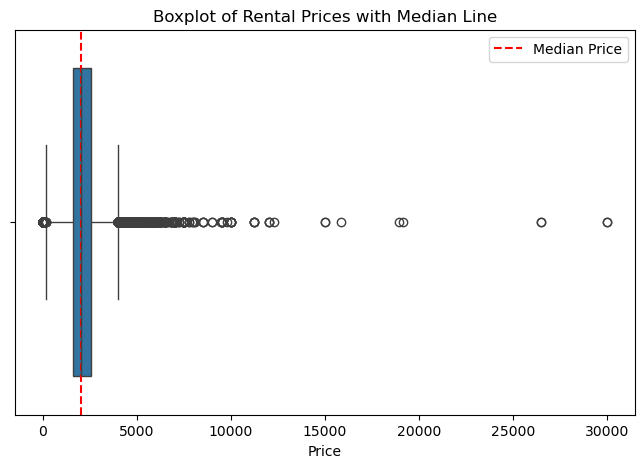

In [10]:

plt.figure(figsize=(8, 5)) 
ax = sns.boxplot(x=canadian_rental['price'])

# Add median line
plt.axvline(canadian_rental['price'].median(), color='red', linestyle='--', label='Median Price')

plt.title("Boxplot of Rental Prices with Median Line")
plt.xlabel("Price")
plt.legend()
plt.show()

Have a better idea if the size of appartment is bigger the price is higher. positive correlation between Price and Square feet.

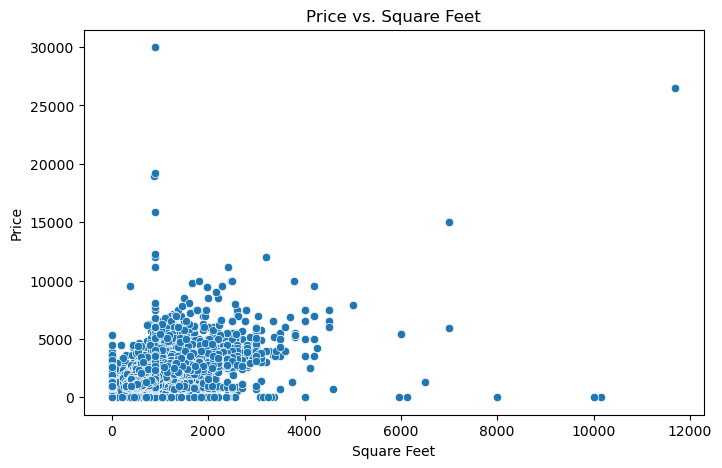

In [11]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=canadian_rental['clean_sq_feet'], y=canadian_rental['price'])
plt.title("Price vs. Square Feet")
plt.xlabel("Square Feet")
plt.ylabel("Price")
plt.show()

Reduce feature numbers:

1- By heatmap corrolation I decided to remove features with negative or very low corrolation with price so 'latitude','longitude','availability_date_numeric','rentfaster_id' would be removed

2- Remove high Cardinality features
Removed  'address','link' columns with too many unique values

city: 269 unique values

province: 10 unique values

address: 8003 unique values

lease_term: 6 unique values

type: 15 unique values

link: 9615 unique values

furnishing: 4 unique values

smoking: 4 unique values

clean_availability_date: 130 unique values

pets: 3 unique values


city: 269 unique values
province: 10 unique values
address: 8003 unique values
lease_term: 6 unique values
type: 15 unique values
link: 9615 unique values
furnishing: 4 unique values
smoking: 4 unique values
clean_availability_date: 130 unique values
pets: 3 unique values


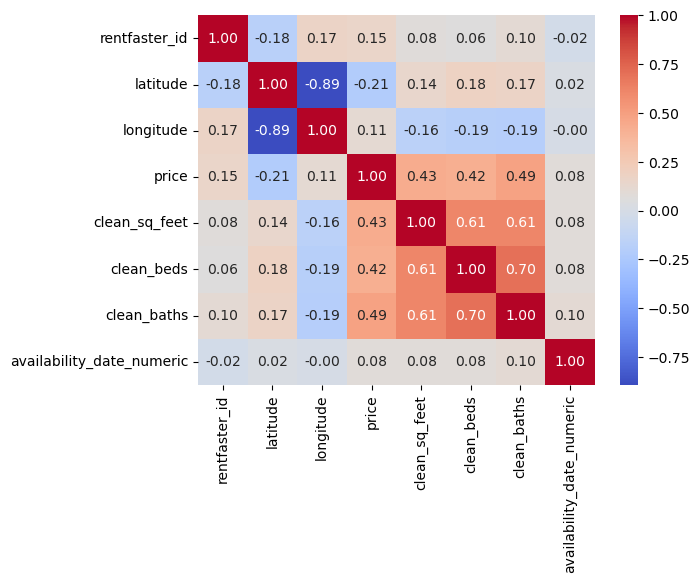

In [12]:
#Reduce feature numbers

# 1-By heatmap corrolation removed'latitude','longitude','availability_date_numeric','rentfaster_id'

# We need to remove few features that does not have high correlations with price like 'latitude','longitude','availability_date_numeric','rentfaster_id'
canadian_rental_numeric = canadian_rental.select_dtypes(['int64','float64','number'])
sns.heatmap(canadian_rental_numeric.corr(),annot=True, cmap='coolwarm',fmt='.2f')
canadian_rental.drop(columns=['availability_date_numeric','rentfaster_id'],axis=1,inplace=True)

# 'latitude','longitude',
categorical_cols = canadian_rental.select_dtypes(include=['object']).columns

#2-Remove high Cardinality features

#Drop columns with too many unique values
for col in categorical_cols:
    print(f"{col}: {canadian_rental[col].nunique()} unique values")

canadian_rental.drop(columns=['address','link'],axis=1,inplace=True)


Encoding the categorical features are done with OneHotEnncoder as we have 7 categorical features and it will be lots of data to encode.

In [13]:
# #Encoding categorical columns
# #Use OneHotEncoding for categorical variables

# Define categorical columns
categorical_cols = ['city', 'province', 'lease_term', 'type', 'furnishing', 'smoking', 'pets']

# Initialize OneHotEncoder
onehot_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Apply OneHotEncoder on categorical columns
canadian_rental_encoded_categoric = onehot_enc.fit_transform(canadian_rental[categorical_cols])

# Convert to DataFrame and restore column names
encoded_cats_df = pd.DataFrame(canadian_rental_encoded_categoric, columns=onehot_enc.get_feature_names_out())

# Select numerical columns (excluding target variable 'price')
numerical_cols = [col for col in canadian_rental.select_dtypes(include=['float64', 'int64', 'number']).columns if col != 'price']

# Concatenate numerical and encoded categorical features
canadian_rental_encoded_all = pd.concat([encoded_cats_df, canadian_rental[numerical_cols].reset_index(drop=True)], axis=1)
canadian_rental_encoded_all.head(3)


,city_Abbotsford,city_Airdrie,city_Ajax,city_Aldersyde,city_Amherstview,city_Ancaster,city_Assiniboia,city_Aurora,city_Ayr,city_Balzac,...,smoking_Smoke Free Building,smoking_Smoking Allowed,pets_False,pets_True,pets_nan,latitude,longitude,clean_sq_feet,clean_beds,clean_baths
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,51.305962,-114.012515,1403.0,2,2.5
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,51.305962,-114.012515,1496.0,3,2.5
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,51.305962,-114.012515,1180.0,2,2.5


In [14]:
canadian_rental_encoded_categoric.shape, encoded_cats_df.columns

((25771, 311),
 Index(['city_Abbotsford', 'city_Airdrie', 'city_Ajax', 'city_Aldersyde',
        'city_Amherstview', 'city_Ancaster', 'city_Assiniboia', 'city_Aurora',
        'city_Ayr', 'city_Balzac',
        ...
        'furnishing_Negotiable', 'furnishing_Unfurnished',
        'furnishing_Unfurnished, Negotiable', 'smoking_Negotiable',
        'smoking_Non-Smoking', 'smoking_Smoke Free Building',
        'smoking_Smoking Allowed', 'pets_False', 'pets_True', 'pets_nan'],
       dtype='object', length=311))

Split the data set to training set and testing set Here is the size of each set 

In [16]:
#Split Data into Training and Testing sets
# Separate features and target variable
X = canadian_rental_encoded_all
y = canadian_rental['price']

# Use Random state to get the same train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20616, 316), (5155, 316), (20616,), (5155,))

We need to select the best features and I used the selctKBest model with 'Mutual_info_regression' score and the top 5 feature.

Here is the top 5 features ['city', 'type', 'clean_sq_feet', 'clean_beds', 'clean_baths'] but I decided to choose the selected features based on the decision above. So the Selected features would come in X_train

In [18]:
# Initialize SelectKBest with mutual_info_regression, choose top 5 features
selector = SelectKBest(score_func=mutual_info_regression, k=5)

# Fit and transform training data only
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)  # Apply same selection to test set

# Get the selected feature names
selected_features = selector.get_feature_names_out(X.columns)

# View top 5 features
#array(['city', 'type', 'clean_sq_feet', 'clean_beds', 'clean_baths'])
selected_features

array(['latitude', 'longitude', 'clean_sq_feet', 'clean_beds',
       'clean_baths'], dtype=object)

Scale the X_train_selected and X_test_selected to normalize the data and get it ready for regression models.

In [20]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit-transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform only on test data
X_test_scaled = scaler.transform(X_test)


Train the Linear Regression Model. and train the data.

In [21]:
# Create instance of model
slr_model = LinearRegression()

# Train model
slr_model.fit(X_train_scaled, y_train)


LinearRegression()

Predict the price with Linear Regression model.

In [22]:
# Obtain y hat values
y_pred = slr_model.predict(X_test_scaled)
slr_model.coef_

array([-4.92717802e+14, -2.91581767e+14, -1.40925839e+14, -4.15414806e+13,
       -5.32804709e+13, -3.76758961e+13,  4.28338820e+13, -1.45868562e+14,
       -3.76758961e+13, -2.93749751e+13, -2.93749751e+13, -2.96221067e+14,
       -1.01730746e+14, -1.46223655e+14,  1.24826469e+15, -4.15414806e+13,
       -7.53463092e+13, -2.93749751e+13, -5.08764812e+13, -1.03398246e+14,
        1.33030575e+14,  1.32411995e+15, -1.21069115e+14, -2.93749751e+13,
       -5.32804709e+13, -5.32804709e+13, -3.76758961e+13, -3.66381034e+14,
       -1.79082328e+14, -2.09617822e+14, -5.32804709e+13,  6.52011513e+14,
       -1.13005755e+14, -1.05882148e+14,  1.62920610e+14, -4.15414806e+13,
       -2.55251312e+14, -6.59536243e+14, -6.52534007e+13, -2.04783407e+15,
       -2.55251312e+14, -2.53655129e+14, -1.27986635e+14,  1.33030575e+14,
       -7.19449737e+13, -5.32804709e+13, -2.93749751e+13, -2.09617822e+14,
       -1.46789355e+14, -2.53655129e+14,  4.28338820e+13, -3.76758961e+13,
       -1.90182193e+14, -

Calculate the error metrics to evaluate the model.

In [23]:
# Obtain metrics
MAE_Lreg = mean_absolute_error(y_test, y_pred)
MSE_Lreg = mean_squared_error(y_test, y_pred)
RMSE_Lreg = np.sqrt(MSE_Lreg)

MAE_Lreg, MSE_Lreg, RMSE_Lreg

(22210211574193.305, 2.1318956311795637e+29, 461724553297695.44)

Try another Regression model. I chose the Lassocv model. Evaluate the model with error metrics evaluation.

In [33]:
# Create instance of model
lassocv_model = LassoCV(eps=0.01,n_alphas=200,cv=10)

# Fit the model on scaled_X_train
lassocv_model.fit(X_train_scaled, y_train)

# Evaluate lassocv model
y_pred = lassocv_model.predict(X_test_scaled)

lassocv_model.alpha_
print("Lasso Coefficients:", lassocv_model.coef_)

# Obtain metrics

MAE_Lasso = mean_absolute_error(y_test, y_pred)
MSE_Lasso = mean_squared_error(y_test, y_pred)
RMSE_Lasso = np.sqrt(MSE_Lasso)

MAE_Lasso, MSE_Lasso, RMSE_Lasso

Lasso Coefficients: [-8.23909731e+00  9.14688859e+00 -0.00000000e+00  7.78604138e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.32923825e+01
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.80248879e+00
 -0.00000000e+00 -0.00000000e+00  2.95632336e+00 -1.14073922e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.50229729e-01 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  8.53992714e-01  1.68249781e+01
 -1.84676405e+00 -4.59474801e+00 -0.00000000e+00  0.00000000e+00
 -5.52536323e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  6.88306024e+00  3.27536137e+01 -0.00000000e+00  1.58741943e+02
  0.00000000e+00 -3.03387792e-01 -8.00320287e-01 -0.00000000e+00
  2.82601829e+01  0.00000000e+00 -0.00000000e+00 -6.85125810e+00
  0.00000000e+00 -3.50606287e+00 -0.00000000e+00 -8.78863994e-01
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.60331500e+00
 -0.00000000e+00  1.90038386e+01 -0.00000000e+00 -0.00000000e+00
 -0.0

(348.9628885305955, 377222.32835240546, 614.1842788222485)

Try another regression model which is polynimial features.

In [24]:
# Create an instance of PolynomialFeatures

poly_converter = PolynomialFeatures(degree=2, include_bias=False)

# Fit converter to X features + transform features

poly_features = poly_converter.fit_transform(X_train_scaled)
# Compare shape of X vs. shape of new features

X_train_scaled.shape, poly_features.shape

((20616, 316), (20616, 50402))

Add training and testing set to the polynomial feature train set (poly_features)

In [25]:
# Train/test split
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(poly_features, y_train, test_size=0.2, random_state=1)
X_train_poly.shape, X_test_poly.shape, y_train_poly.shape, y_test_poly.shape

((16492, 50402), (4124, 50402), (16492,), (4124,))

Add the train polynimal feature to regressin model to have the predictions with poly features.

In [26]:
# Create instance of model

model_poly = LinearRegression()

# Train regression model on 65 features instead of 10

model_poly.fit(X_train_poly, y_train_poly)

LinearRegression()

Calculate the error metrics to evaluate the model.

In [ ]:
y_pred_poly = model_poly.predict(X_test_poly)

# Obtain metrics
MAE_poly = mean_absolute_error(y_test_poly, y_pred_poly)
MSE_poly = mean_squared_error(y_test_poly, y_pred_poly)
RMSE_poly = np.sqrt(MSE_poly)

MAE_poly, MSE_poly, RMSE_poly

(16321769761189.451, 5.617430945635685e+28, 237011201120024.8)

----------------------------------------

Polynomial Regression: MAE, MSE, RMSE 

(376.7237629345819, 693710.424188604, 832.8928047405644) 

(16321769761189.451, 5.617430945635685e+28, 237011201120024.8)

-----------------------------------

LassoCV Regression: MAE, MSE, RMSE 

(398.46497277111985, 458371.42585607636, 677.0313329943278) 

(348.9628885305955, 377222.32835240546, 614.1842788222485)

-----------------------------------

Linear Regression: MAE, MSE, RMSE 

(399.05462396375714, 458467.01963399217, 677.1019270641549) 

(22210211574193.305, 2.1318956311795637e+29, 461724553297695.44)

-----------------------------------


Comparing Models Based on Metrics


Polynomial Regression----	16321769761189.45 X ----5.61 O----237011201120024.8 X

LassoCV Regression----	348.96 O----458371.42 X----614.18 O

Linear Regression----	22210211574193.3 X----2.13 O----461724553297695.4 X

------------------------------------

LassoCV is the best model out of 3 regression models above. As it has the lower MSE and RMSE in entire error metrics.

-------------------------------------


In [ ]:
#Save the lassoCV model
import joblib

# Save the trained model
joblib.dump(lassocv_model, 'rental_price_model.pkl')

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

# Define a new rental listing
new_listing = {
    "city": "Montreal",
    "province": "Quebec",
    "lease_term": "12 months",
    "type": "Apartment",
    "furnishing": "Unfurnished",
    "smoking": "No",
    "latitude": 51.305962,	
    "longitude": -114.012515,
    "clean_sq_feet": 800,
    "clean_beds": 2,
    "clean_baths": 1.5,
    "pets" : "yes"
}

#     'province_Alberta': 0,
#     'type_Apartment': 'Apartment',
#     'clean_sq_feet': 800,
#     'clean_beds': 2,
#     'clean_baths': 1.5
# }
# Convert to DataFrame
new_input_df = pd.DataFrame([new_listing])

# # Define categorical and numerical columns
categorical_cols = ["city", "province", "lease_term", "type", "furnishing", "smoking", "pets"]
numerical_cols = ["latitude", "longitude","clean_sq_feet", "clean_beds", "clean_baths"]

# # Apply One-Hot Encoding
new_encoded_array = onehot_enc.transform(new_input_df[categorical_cols])


In [ ]:
# Before concatination I need to put this in dataframe
new_encoded_df = pd.DataFrame(new_encoded_array, columns=target_enc.get_feature_names_out())

# Combine categorical and numerical data
new_input_df = pd.concat([new_encoded_df, new_input_df[numerical_cols].reset_index(drop=True)], axis=1)
new_input_df.shape

In [ ]:
# Apply StandardScaler
scaled_df  = scaler.transform(new_input_df)


In [ ]:
# Make Prediction
predicted_price = lassocv_model.predict(scaled_df)

# Display Result
print(f"Predicted Rental Price: ${predicted_price[0]:,.2f}")

This prediction is with dropping: 'latitude','longitude','availability_date_numeric','rentfaster_id', 'Address' and 'Link'

size of the scaled data (1,314)

Predicted Rental Price: $2,079.11

This prediction is with dropping only 4 features: 'availability_date_numeric','rentfaster_id', 'Address' and 'Link'

size of the scaled dataframe (1,316)

Predicted Rental Price: $1,874.34

Best result is still found in website.
$1849-1899
Apartment  
2   bd    
1.5   ba   
970 - 1070   ft2  
Pets Ok
Immediate availability

So, the best result came with keeping all features except 4  

'availability_date_numeric','rentfaster_id', 'Address' and 'Link'. 

The result is similar to what faster rent website would find with similar search.